In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [72]:
df = pd.read_csv('SPY.csv',index_col='Date',parse_dates=True)

In [73]:
#make features
df['FastSMA'] = df['Close'].rolling(16).mean()
df['SlowSMA'] = df['Close'].rolling(33).mean()
feats = ['FastSMA','SlowSMA']

In [74]:
df['LogReturn'] = np.log(df['Close']).diff()

In [75]:
Ntest = 1000
train_data = df.iloc[:-Ntest].copy()
test_data = df.iloc[-Ntest:].copy()

In [76]:
class Env:
    def __init__(self,df):
        self.df = df
        self.n = len(df)
        self.current_idx = 0
        self.action_space = [0,1,2] # BUY, SELL, HOLD
        self.invested =0
        
        self.states = self.df[feats].to_numpy()
        self.rewards = self.df['LogReturn'].to_numpy()
        self.total_buy_and_hold = 0
    
    def reset(self):
        self.current_idx =0
        self.total_buy_and_hold = 0
        self.invested = 0
        return self.states[self.current_idx]
    
    def step(self, action):
        # need to return (next_state,reward, done)
        self.current_idx += 1
        if self.current_idx >= self.n:
            raise Exception("Episode Already Done")
        
        if action == 0: #BUY
            self.invested = 1
        elif action == 1: # SELL
            self.invested = 0
        
        # compute reward
        if self.invested:
            reward = self.rewards[self.current_idx]
        else:
            reward = 0
        
        # state trasition
        next_state = self.states[self.current_idx]
        
        #baseline
        self.total_buy_and_hold += self.rewards[self.current_idx]
        
        # done flag
        done = (self.current_idx == self.n - 1)
        return next_state, reward, done
        
            

In [77]:
class Agent:
    def __init__(self):
        self.is_invested =False
        
    def act(self,state):
        assert(len(state)==2)
        #(fast,slow)
        
        if state[0] > state[1] and not self.is_invested:
            self.is_invested = True
            return 0 # Buy
        
        
        if state[0] < state[1] and self.is_invested:
            self.is_invested = False
            return 1 # Sell
        
        return 2 # Do nothing

In [78]:
def play_one_episode(agent, env):
    state = env.reset()
    done = False
    total_reward = 0
    agent.is_invested = False
    
    while not done:
        action = agent.act(state)
        next_state, reward, done =env.step(action)
        total_reward += reward
        state = next_state
    return total_reward

In [79]:
train_env = Env(train_data)
test_env = Env(test_data)

In [80]:
agent = Agent()

In [81]:
train_reward = play_one_episode(agent,train_env)
test_reward = play_one_episode(agent,test_env)


In [82]:
train_reward, train_env.total_buy_and_hold

(0.43459304796456966, 0.5970866514889401)

In [83]:
test_reward, test_env.total_buy_and_hold

(0.08889132894199303, 0.19307543946998518)

In [84]:
## agent and env make interaction
##
##

In [85]:
import itertools

In [86]:
df0 = pd.read_csv('sp500_closefull.csv', index_col=0, parse_dates=True)
df0.dropna(axis=0, how= 'all', inplace= True)
df0.dropna(axis=1, how= 'any', inplace= True)

In [87]:
df0

,CSCO,UAL,TROW,ISRG,PRGO,TPR,DVN,MRO,BA,VRTX,...,M,CRM,PGR,WAT,BWA,LRCX,NWL,UAA,BLK,PPL
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,24.690001,12.800000,54.400002,102.923332,40.349998,36.310001,76.570000,19.153616,56.180000,44.240002,...,17.059999,18.705000,18.030001,61.630001,16.889999,39.880001,15.200000,3.510000,238.580002,30.242558
2010-01-05,24.580000,13.910000,55.009998,102.459999,38.790001,36.750000,76.650002,19.171511,58.020000,42.779999,...,16.860001,18.625000,17.969999,60.790001,17.695000,39.610001,15.110000,3.615000,239.610001,29.851370
2010-01-06,24.420000,13.270000,54.150002,103.946663,38.299999,37.470001,76.419998,19.595024,59.779999,42.029999,...,17.100000,18.592501,17.790001,60.900002,18.344999,39.430000,15.380000,3.695000,234.669998,29.916569
2010-01-07,24.530001,13.550000,54.110001,103.556664,37.990002,37.490002,75.970001,19.475725,62.200001,41.500000,...,17.490000,18.510000,17.549999,61.160000,18.594999,39.360001,15.820000,3.651250,237.250000,29.627834
2010-01-08,24.660000,13.330000,53.900002,102.986664,37.779999,37.270000,76.120003,19.505550,61.599998,40.669998,...,16.920000,18.537500,17.709999,61.209999,18.254999,40.349998,15.770000,3.643750,238.919998,29.534695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-21,41.849998,81.470001,86.779999,446.019989,37.029999,32.810001,21.910000,13.450000,304.549988,156.500000,...,28.200001,122.910004,59.419998,176.559998,33.770000,127.160004,18.860001,16.959999,369.160004,28.400000
2018-12-24,40.279999,79.120003,84.949997,434.890015,36.500000,32.299999,20.980000,12.660000,294.160004,151.910004,...,28.150000,121.330002,57.070000,173.539993,33.200001,123.279999,17.950001,16.750000,361.769989,27.590000
2018-12-26,42.470001,83.800003,89.650002,461.980011,40.700001,33.889999,22.709999,14.170000,313.929993,161.839996,...,30.129999,130.839996,59.330002,181.190002,34.400002,130.839996,18.910000,17.820000,381.230011,28.309999


In [88]:
np.log(df0['CSCO']).diff()

Date
2010-01-04         NaN
2010-01-05   -0.004465
2010-01-06   -0.006531
2010-01-07    0.004494
2010-01-08    0.005286
                ...   
2018-12-21   -0.015177
2018-12-24   -0.038237
2018-12-26    0.052943
2018-12-27    0.010307
2018-12-28   -0.003268
Name: CSCO, Length: 2263, dtype: float64

In [89]:
df_returns =pd.DataFrame()
for name in df0.columns:
    df_returns[name] = np.log(df0[name]).diff()


/var/folders/6z/zfrlwktn1ls42xz760mlmp880000gn/T/ipykernel_8634/562093637.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_returns[name] = np.log(df0[name]).diff()
/var/folders/6z/zfrlwktn1ls42xz760mlmp880000gn/T/ipykernel_8634/562093637.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_returns[name] = np.log(df0[name]).diff()
/var/folders/6z/zfrlwktn1ls42xz760mlmp880000gn/T/ipykernel_8634/562093637.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many tim

In [90]:
Ntest = 1000
train_data = df_returns.iloc[:-Ntest]
test_data = df_returns.iloc[-Ntest:]

In [91]:
feats =['AAPL','MSFT','AMZN']

In [92]:
class Env:
    def __init__(self,df):
        self.df = df
        self.n = len(df)
        self.current_idx = 0
        self.action_space = [0,1,2] # BUY, SELL, HOLD
        self.invested =0
        
        self.states = self.df[feats].to_numpy()
        self.rewards = self.df['SPY'].to_numpy()
    
    def reset(self):
        self.current_idx =0
        return self.states[self.current_idx]
    
    def step(self, action):
        # need to return (next_state,reward, done)
        self.current_idx += 1
        if self.current_idx >= self.n:
            raise Exception("Episode Already Done")
        
        if action == 0: #BUY
            self.invested = 1
        elif action == 1: # SELL
            self.invested = 0
        
        # compute reward
        if self.invested:
            reward = self.rewards[self.current_idx]
        else:
            reward = 0
        
        # state trasition
        next_state = self.states[self.current_idx]
        
        # done flag
        done = (self.current_idx == self.n - 1)
        return next_state, reward, done
        
            

In [93]:
class StateMapper:
    def __init__(self,env,n_bins=6,n_samples=100000):
        #first, collect sample states from the env
        states = []
        done = False
        s =env.reset()
        self.D = len(s) # number of elements we need to bin
        states.append(s)
        for _ in range(n_samples):
            a = np.random.choice(env.action_space)
            s2, _, done =env.step(a)
            states.append(s2)
            if done:
                s = env.reset()
                states.append(s)
        #convert to numpy array for easy indexing
        states = np.array(states)
        # create the bins for each dimension:
        self.bins = []
        for d in range(self.D):
            column = np.sort(states[:,d])
            #find the boundaries for each bin
            current_bin = []
            for k in range(n_bins):
                boundary = column[int(n_samples/n_bins*(k+0.5))]
                current_bin.append(boundary)
            self.bins.append(current_bin)
            
    def transform(self,state):
        x = np.zeros(self.D)
        for d in range(self.D):
            x[d]= int(np.digitize(state[d],self.bins[d]))
        return tuple(x)
    
    def all_possible_states(self):
        list_of_bins = []
        for d in range(self.D):
            list_of_bins.append(list(range(len(self.bins[d])+1)))
        return itertools.product(*list_of_bins)    

In [94]:
class Agent:
    def __init__(self,action_size,state_mapper):
        self.action_size = action_size
        self.gamma = 0.8 # dc rate
        self.epsilon = 0.1
        self.learning_rate = 1e-1
        self.state_mapper =state_mapper
        # initialize Q-table randomly
        self.Q = {}
        for s in self.state_mapper.all_possible_states():
            s = tuple(s)
            for a in range(self.action_size):
                self.Q[(s,a)] = np.random.randn()
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)
        s =self.state_mapper.transform(state)
        act_values = [self.Q[(s,a)] for a  in range(self.action_size)]
        return np.argmax(act_values)
    def train(self,state,action,reward,next_state,done):
        s = self.state_mapper.transform(state)
        s2 =self.state_mapper.transform(next_state)
        
        if done:
            target = reward
        else:
            act_values= [self.Q[(s2,a)] for a in range(self.action_size)]
            target = reward + self.gamma * np.amax(act_values)
        # RUn one training step
        self.Q[(s,action)] += self.learning_rate * (target - self.Q[(s,action)])
        
    
        

In [95]:
def play_one_episode(agent,env,is_train):
    state= env.reset()
    done =False
    total_reward=0
    
    while not done:
        action = agent.act(state)
        next_state,reward,done = env.step(action)
        total_reward += reward
        if is_train:
            agent.train(state,action,reward,next_state,done)
        state = next_state
    return total_reward

In [96]:
num_episodes = 500

In [97]:
train_env = Env(train_data)
test_env = Env(test_data)

In [98]:
action_size = len(train_env.action_space)
state_mapper = StateMapper(train_env)
agent = Agent(action_size,state_mapper)

In [99]:
train_rewards = np.empty(num_episodes)
test_rewards = np.empty(num_episodes)

In [100]:
for e in range(num_episodes):
    r = play_one_episode(agent,train_env,is_train= True)
    train_rewards[e] = r
    # test on the test set
    tmp_epsilon= agent.epsilon
    agent.epsilon=0.
    tr = play_one_episode(agent,test_env,is_train=False)
    agent.epsilon=tmp_epsilon
    test_rewards[e]=tr
    print(f" eps:{e+1}/{num_episodes}, train: {r:.5f}, test: {tr:.5f}  ")

 eps:1/500, train: 0.49972, test: 0.18405  
 eps:2/500, train: 0.46039, test: 0.14650  
 eps:3/500, train: 0.34463, test: 0.15150  
 eps:4/500, train: 0.44028, test: 0.13679  
 eps:5/500, train: 0.38190, test: 0.07773  
 eps:6/500, train: 0.42745, test: 0.20575  
 eps:7/500, train: 0.46928, test: 0.35996  
 eps:8/500, train: 0.40640, test: 0.13710  
 eps:9/500, train: 0.34589, test: 0.11507  
 eps:10/500, train: 0.43449, test: 0.22856  
 eps:11/500, train: 0.55286, test: 0.27925  
 eps:12/500, train: 0.24231, test: 0.18985  
 eps:13/500, train: 0.57333, test: 0.16809  
 eps:14/500, train: 0.33749, test: 0.25669  
 eps:15/500, train: 0.19089, test: 0.12060  
 eps:16/500, train: 0.39736, test: 0.40996  
 eps:17/500, train: 0.38311, test: 0.30407  
 eps:18/500, train: 0.38669, test: -0.02516  
 eps:19/500, train: 0.30309, test: 0.19805  
 eps:20/500, train: 0.28606, test: 0.08171  
 eps:21/500, train: 0.41875, test: 0.17767  
 eps:22/500, train: 0.44569, test: 0.23540  
 eps:23/500, train

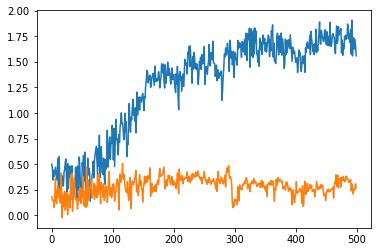

In [101]:
plt.plot(train_rewards)
plt.plot(test_rewards);